In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.CRITICAL)

In [3]:
# # dataset = "mnist"
# dataset = "kmnist"
# algo = "modular"
# # algo = "monolithic"

# experiment_folder = "experiment_results"
# experiment_name = "vanilla_fix_bug_compute_loss_encodev2"


# use_contrastive = True
# num_trains_per_class = 64
# seed = 0

# save_dir = get_save_dir(experiment_folder, experiment_name,
#                         dataset, algo, num_trains_per_class, use_contrastive, seed)


In [4]:
def plot_agg_learning_curves(fleet, ax=None, name=None, tasks=None, agent_ids=None, viz=True, mode="current",
                             metric="test_acc"):
    if ax is None and viz:
        fig, ax = plt.subplots()

    if tasks is None:
        tasks = range(fleet.num_init_tasks-1, fleet.agents[0].net.num_tasks)

    dfs = []
    for agent in fleet.agents:
        if agent_ids is not None and agent.node_id not in agent_ids:
            continue
        df = agent.agent.record.df
        for task in tasks:
            task_df = df[df["train_task"] == task]
            if mode == "current":
                task_df = task_df[task_df["test_task"] == str(task)]
            elif mode == "avg":
                task_df = task_df[task_df["test_task"] == 'avg']
            else:
                raise ValueError("mode must be current or avg")
            task_df['agent_id'] = agent.node_id
            # print(task_df)
            dfs.append(task_df)

    combined_df = pd.concat(dfs)


    agg_df = combined_df.groupby(['epoch']).agg({metric: ['mean', 'std']}).reset_index()

    # Extract mean and standard deviation values
    mean_test_acc = agg_df[metric]['mean']
    std_test_acc = agg_df[metric]['std']

    if viz:
        # Plot the mean test_acc with shaded areas for standard deviation
        ax.plot(agg_df['epoch'], mean_test_acc, 
                label=name)
        plt.fill_between(agg_df['epoch'], mean_test_acc - 0.1 * std_test_acc, mean_test_acc + 0.1 * std_test_acc, alpha=0.3)

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Test Accuracy')
        if name is not None:
            ax.legend();

    # compute area under the curve
    auc = np.trapz(mean_test_acc, agg_df['epoch'])
    return auc, agg_df

In [5]:
# fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)

In [6]:
# fleet.load_records()

In [7]:
# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
#             "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"]

# for task in range(max_task+1):
# # for task in range(0, 5):
# # for task in range(19, 20):
#     task_df = df[df["train_task"] >= task]
#     # get task_df of only test_task == task
#     task_df = task_df[task_df["test_task"] == str(task)]
#     # smooth out the test_acc
#     # task_df["test_acc"] = task_df["test_acc"].rolling(5).mean()
#     plt.plot(task_df["time"], task_df["test_acc"], label=f"task {task}",
#              color=colors[task],)
# plt.legend();

In [8]:
# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
#             "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"]


# mean_test_acc_all_agents = []
# std_test_acc_all_agents = []

# for agent in fleet.agents:
#     df = agent.agent.record.df
#     df['time'] = df.index


# # Iterate through each task
# for task in range(fleet.agents[0].net.num_tasks):
#     # Initialize an empty list to store the test accuracy data for this task across all agents
#     test_acc_task_all_agents = []
    
#     # Iterate through each agent
#     for agent in fleet.agents:
#         df = agent.agent.record.df
#         # Filter the dataframe to get task_df for the current task for this agent
#         task_df = df[df["train_task"] >= task]
#         task_df = task_df[task_df["test_task"] == str(task)]
#         # Extract the test accuracy data and append it to the list
#         test_acc_task_all_agents.append(task_df["test_acc"].values)
    
#     # Calculate the mean test accuracy for this task across all agents
#     mean_test_acc_task = np.mean(test_acc_task_all_agents, axis=0)
#     mean_test_acc_all_agents.append(mean_test_acc_task)


#     std_test_acc_task = np.std(test_acc_task_all_agents, axis=0)
#     std_test_acc_all_agents.append(std_test_acc_task)


# # Plot the mean test accuracy for each task
# for task, (mean_test_acc_task, std_test_acc_task) in enumerate(zip(mean_test_acc_all_agents, std_test_acc_all_agents)):
#     task_df = df[df["train_task"] >= task]
#     task_df = task_df[task_df["test_task"] == str(task)]
#     plt.plot(task_df["time"], mean_test_acc_task, label=f"Task {task}", color=colors[task])
#     # plt.fill_between(task_df["time"], mean_test_acc_task - std_test_acc_task, mean_test_acc_task + std_test_acc_task, color=colors[task], alpha=0.3)


# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xlabel("Time")
# plt.ylabel("Test Accuracy")
# plt.title("Learning Curve")
# plt.show()


In [9]:
# dataset = "mnist"
# # dataset = "kmnist"

# experiment_folder = "experiment_results"
# experiment_name = "vanilla_fix_bug_compute_loss_encodev2"


# use_contrastive = True
# num_trains_per_class = 64
# seed = 5

# save_dir1 = get_save_dir(experiment_folder, experiment_name,
#                         dataset, "modular", num_trains_per_class, use_contrastive, seed)

# save_dir2 = get_save_dir(experiment_folder, experiment_name,
#                         dataset, "monolithic", num_trains_per_class, use_contrastive, seed)
# def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
#     cfg.sharing_strategy['sync_base'] = False
#     return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

# fleet1 = setup_fleet(save_dir1, modify_cfg=modify_cfg, parallel=False)
# fleet1.load_records()

# fleet2 = setup_fleet(save_dir2, modify_cfg=modify_cfg, parallel=False)
# fleet2.load_records()

# fig, ax = plt.subplots()
# plot_agg_learning_curves(fleet1, ax, name="modular")
# plot_agg_learning_curves(fleet2, ax, name="monolithic")

In [10]:
# dataset = "mnist"
# # dataset = "kmnist"

# experiment_folder = "experiment_results"
# experiment_name = "vanilla_fix_bug_compute_loss_encodev2"


# use_contrastive = True
# num_trains_per_class = 64
# seed = 7

# save_dir1 = get_save_dir(experiment_folder, experiment_name,
#                         dataset, "modular", num_trains_per_class, use_contrastive, seed)

# save_dir2 = get_save_dir(experiment_folder, experiment_name,
#                         dataset, "monolithic", num_trains_per_class, use_contrastive, seed)
# def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
#     cfg.sharing_strategy['sync_base'] = False
#     return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

# fleet1 = setup_fleet(save_dir1, modify_cfg=modify_cfg, parallel=False)
# fleet1.load_records()

# fleet2 = setup_fleet(save_dir2, modify_cfg=modify_cfg, parallel=False)
# fleet2.load_records()

# fig, ax = plt.subplots()
# plot_agg_learning_curves(fleet1, ax, name="modular")
# plot_agg_learning_curves(fleet2, ax, name="monolithic")

In [11]:
# dataset = "mnist"
# dataset = "kmnist"

datasets = ["mnist", "kmnist", "fashionmnist"]
# datasets = ["mnist"]
# datasets = ["kmnist"]

experiment_folder = "experiment_results"
# base_experiment_name = "vanilla_fix_bug_compute_loss_encodev2"
# base_experiment_name = "vanilla_modular_save_freq_10"
# base_experiment_name = "vanilla_jorge_setting"


use_contrastive = True
num_trains_per_class = 64

viz = False
seeds = [0, 1, 2, 3, 4, 5, 6, 7]
# seeds = [0]
# seeds = [1, 2]


# agent_ids = [1]
# tasks = [7]
tasks=None
agent_ids = None
ax=None
# # sync_bases = [True, False]
sync_bases = [True]
# sync_bases = [False]
opt_with_randoms = [False]

mode = "current"
# mode = "avg"

# metric='test_loss'
metric='test_acc'

def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    if "sync_base" not in cfg.sharing_strategy:
        cfg.sharing_strategy['sync_base'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

algos = ['modular', 'monolithic']
algos = ['modular']
# use_contrastive_list = [True, False]
use_contrastive_list = [False]


freeze_candidate_module = False
transfer_decoder_ls = [True, False]
transfer_structure_ls = [True, False]
# transfer_decoder_ls = [True]
# transfer_structure_ls = [True]
no_sparse_basis_ls = [True, False]
# no_sparse_basis = True
# no_sparse_basis = False




def get_save_dirs(dataset, seed):
    save_dirs = {}
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for no_sparse_basis in no_sparse_basis_ls:
                if no_sparse_basis:
                    base_experiment_name = "vanilla_jorge_setting_basis_no_sparse"
                else:
                    base_experiment_name = "vanilla_jorge_setting"
                name = f'{algo}_no_sparse_basis_{no_sparse_basis}'
                if use_contrastive_opt:
                    name += "_contrastive"
                save_dirs[name] = get_save_dir(experiment_folder, base_experiment_name,
                                        dataset, algo, num_trains_per_class, use_contrastive_opt, seed)

            # if use_contrastive_opt:
            #     continue
            # name = f"all_sparse_{name}"
            # save_dirs[name] = get_save_dir(experiment_folder, base_experiment_name2,
            #                         dataset, algo, num_trains_per_class, use_contrastive_opt, seed)

    for sync_base in sync_bases:
        for opt_with_random in opt_with_randoms:
            for use_contrastive_opt in use_contrastive_list:
                for transfer_decoder in transfer_decoder_ls:
                    for transfer_structure in transfer_structure_ls:
                        for no_sparse_basis in no_sparse_basis_ls:
                            # experiment_name = f"jorge_setting_basis_no_sparse_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_False"
                            experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            # experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_False"
                            # experiment_name = f"lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_False"
                            name = f'jorge_setting_lowest_id_sync_{sync_base}_rand_{opt_with_random}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}'
                            if use_contrastive_opt:
                                name += "_contrastive"
                            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                    dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)
                                            
                # if use_contrastive_opt:
                #     continue
                # experiment_name2 = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_False"
                # name = f"all_sparse_{name}"
                # save_dirs[name] = get_save_dir(experiment_folder, experiment_name2,
                #                         dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)

            # experiment_name = f"modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}"
            # save_dirs[f'highest_id_sync_{sync_base}_rand_{opt_with_random}'] = get_save_dir(experiment_folder, experiment_name,
            #                         dataset, "modular", num_trains_per_class, use_contrastive, seed)
    return save_dirs

In [12]:
def load_data(get_save_dirs, seeds, datasets, modify_cfg, viz, tasks, agent_ids, ax=None, mode="current", 
              metric="test_acc"):
    dataset_seed_aucs = {}
    dataset_agg_dfs = {}
    for dataset in datasets:
        seed_aucs = {}
        agg_dfs = []
        for seed in seeds:
            fleets = {}
            save_dirs = get_save_dirs(dataset, seed)
            for name, save_dir in save_dirs.items():
                    fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)
                    fleet.load_records()
                    fleets[name] = fleet

            if viz:
                fig, ax = plt.subplots()

            aucs = {}
            for title_name, fleet in fleets.items():
                aucs[title_name], agg_df = plot_agg_learning_curves(fleet, ax, name=title_name, tasks=tasks, agent_ids=agent_ids, viz=viz, mode=mode,
                                                                    metric=metric)
                agg_df['seed'] = seed
                agg_df['name'] = title_name
                agg_dfs.append(agg_df)

            combined_agg_df = pd.concat(agg_dfs)
            seed_aucs[seed] = aucs
        
        dataset_seed_aucs[dataset] = seed_aucs
        dataset_agg_dfs[dataset] = combined_agg_df
    
    return dataset_seed_aucs, dataset_agg_dfs

In [13]:
def plot_agg_over_seeds(combined_agg_df, title_name=None, ax=None, std_scale=1.0, metric='test_acc'):
    if title_name is None:
        title_name ='Aggregated Test Accuracy Learning Curves Across All Seeds and Algorithms'
    if ax is None:
        fig, ax = plt.subplots()
    agg_over_seed_name = combined_agg_df.groupby(['name', 'epoch']).agg({(metric, 'mean'): 'mean', (metric, 'std'): 'std'}).reset_index()

    for name, group in agg_over_seed_name.groupby('name'):
        mean_test_acc = group[metric]['mean']
        std_test_acc = group[metric]['std']
        ax.plot(group['epoch'], mean_test_acc, label=name, marker='o')
        ax.fill_between(group['epoch'], mean_test_acc - std_scale * std_test_acc, mean_test_acc + std_scale * std_test_acc, alpha=0.3)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy')
    ax.legend()
    ax.set_title(title_name)
    # ax.set_ylim(0.2, 1);

In [14]:
def plot_learning_curve_bars(seed_aucs, title_name=None, ax=None):
    if title_name is None:
        title_name = 'Aggregated AUC'
    
    if ax is None:
        fig, ax = plt.subplots()

    # Initialize a dictionary to hold aggregated stats
    algo_stats = {}

    # Iterate through each seed and algorithm AUC score
    for seed, auc in seed_aucs.items():
        for algo, auc_ in auc.items():
            # Ignore bad values
            if auc_ <= 0.5:
                continue
            
            # If the algorithm is not yet in the stats dictionary, initialize it
            if algo not in algo_stats:
                algo_stats[algo] = {'total_auc': 0, 'count': 0}
            
            # Accumulate the AUC score and increment the count
            algo_stats[algo]['total_auc'] += auc_
            algo_stats[algo]['count'] += 1

    # Calculate the average AUC for each algorithm
    for algo, stats in algo_stats.items():
        average_auc = stats['total_auc'] / stats['count'] if stats['count'] > 0 else 0
        print(f"{algo}: Average AUC = {average_auc:.2f}")

    # Sort the algo_stats dictionary by average AUC in descending order
    sorted_algo_stats = sorted(algo_stats.items(), key=lambda x: x[1]['total_auc'], reverse=True)


    palette = plt.get_cmap('tab10').colors
    algo_colors = {algo: palette[i % len(palette)] for i, algo in enumerate(sorted(algo_stats))}




    # Plot the bars in descending order of average AUC
    for algo, stats in sorted_algo_stats:
        average_auc = stats['total_auc'] / stats['count'] if stats['count'] > 0 else 0
        ax.bar(algo, average_auc, color=algo_colors[algo])

    ax.tick_params(axis='x', rotation=45)  # Rotate labels
    ax.set_xticklabels(ax.get_xticklabels(), ha="right")  # Align labels to the right

    ax.set_title(title_name)
    ax.set_ylim([60, 95])


In [15]:
dataset_seed_aucs, dataset_agg_dfs = load_data(get_save_dirs, seeds, datasets, modify_cfg, viz, tasks, agent_ids, ax, mode=mode,
                                               metric=metric,)

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0, 'sync_base': False, 'pre_or_post_comm': 'post'}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_jorge_setting_basis_no_sparse', 'parallel': True, 'num_init_tasks': 4, 'overwrite': False, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': False, 'use_ood_separation_loss': False, 'lambda_ood': 2.0, 'delta_ood': 1.0}}
i_s

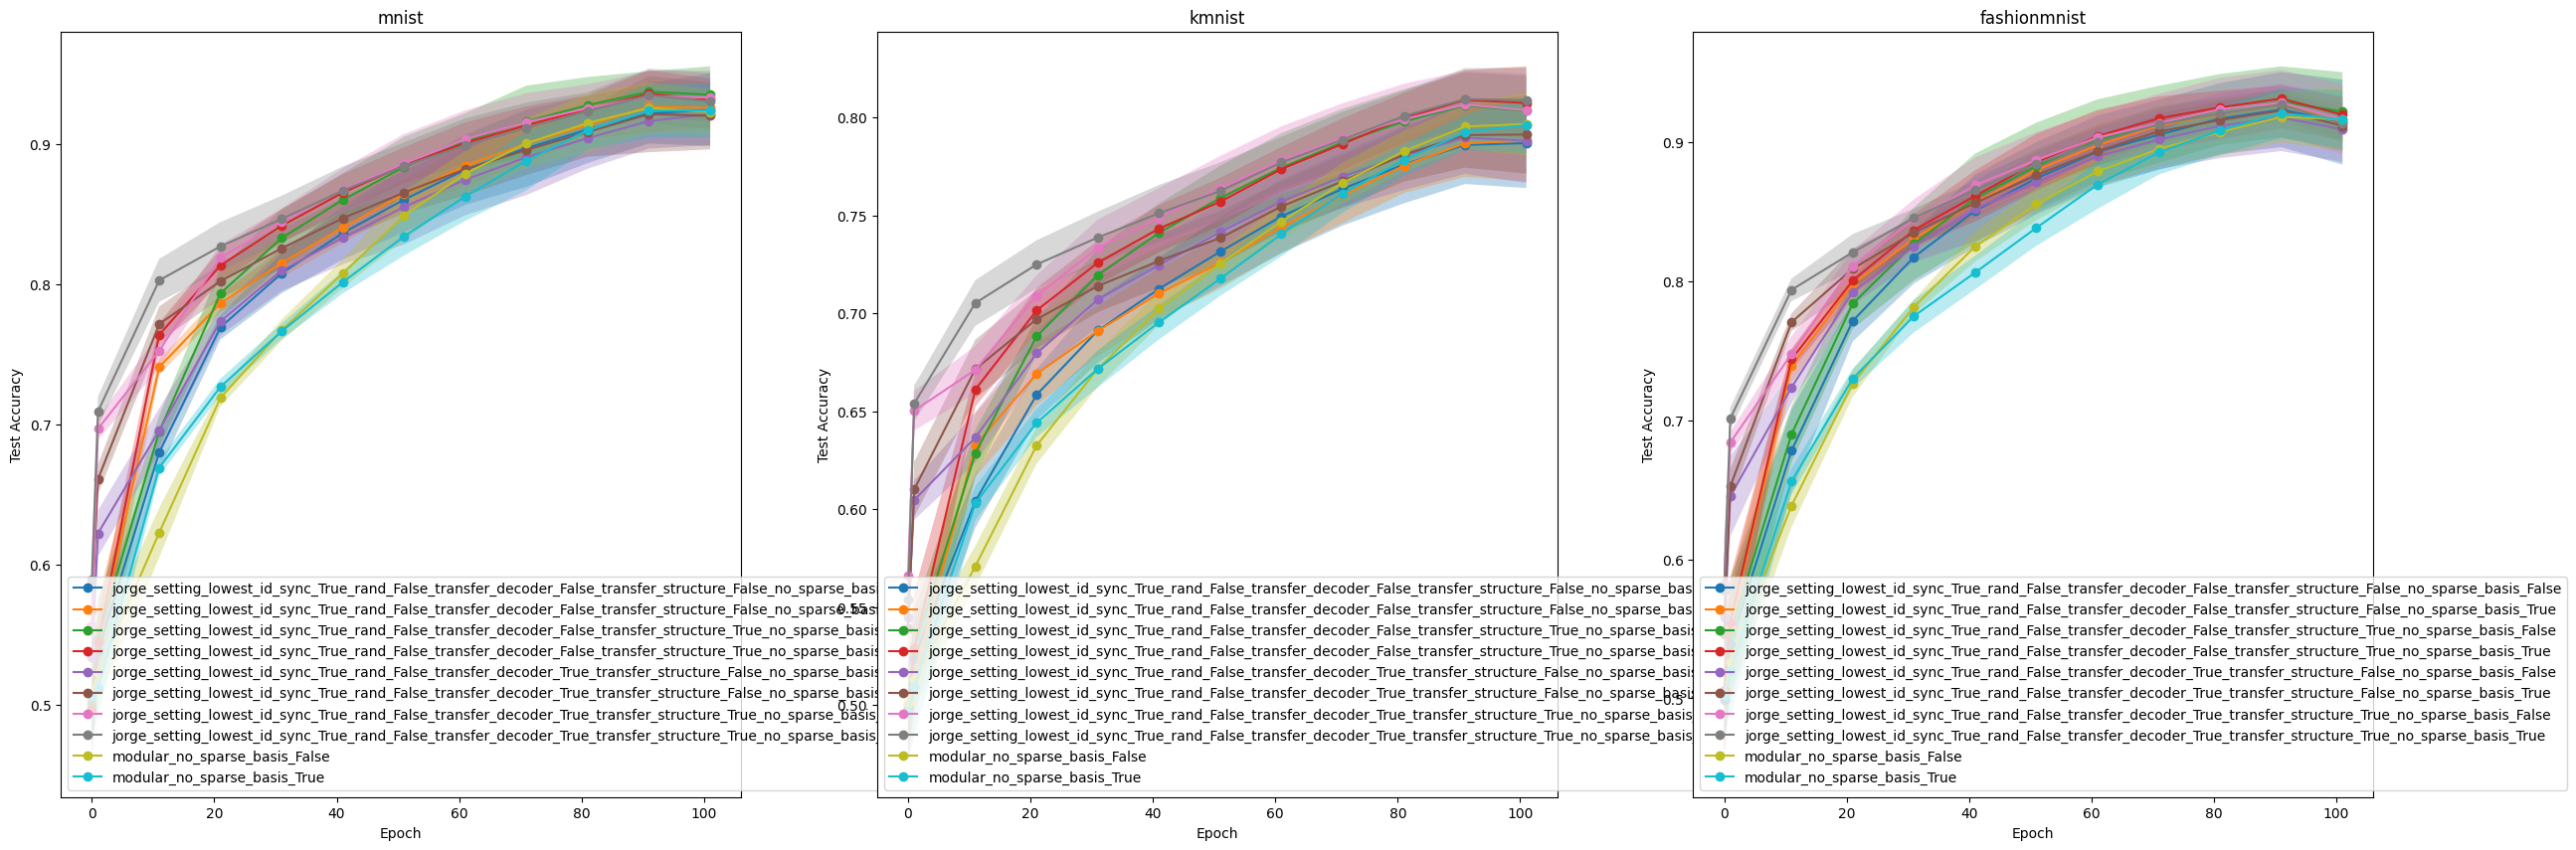

In [19]:
fig, ax = plt.subplots(1, len(dataset_agg_dfs.keys()), figsize=(30, 10))
for i, (dataset, agg_df) in enumerate(dataset_agg_dfs.items()):
    plot_agg_over_seeds(agg_df, title_name=dataset, ax=ax if not isinstance(ax, np.ndarray) else ax[i],metric=metric)



 mnist
modular_no_sparse_basis_True: Average AUC = 81.52
modular_no_sparse_basis_False: Average AUC = 81.62
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True: Average AUC = 87.83
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_False: Average AUC = 87.28
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_False_no_sparse_basis_True: Average AUC = 85.73
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_False_no_sparse_basis_False: Average AUC = 83.84
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True: Average AUC = 86.36
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_False: Average AUC = 85.44
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structur

/tmp/ipykernel_2862788/2028063996.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha="right")  # Align labels to the right


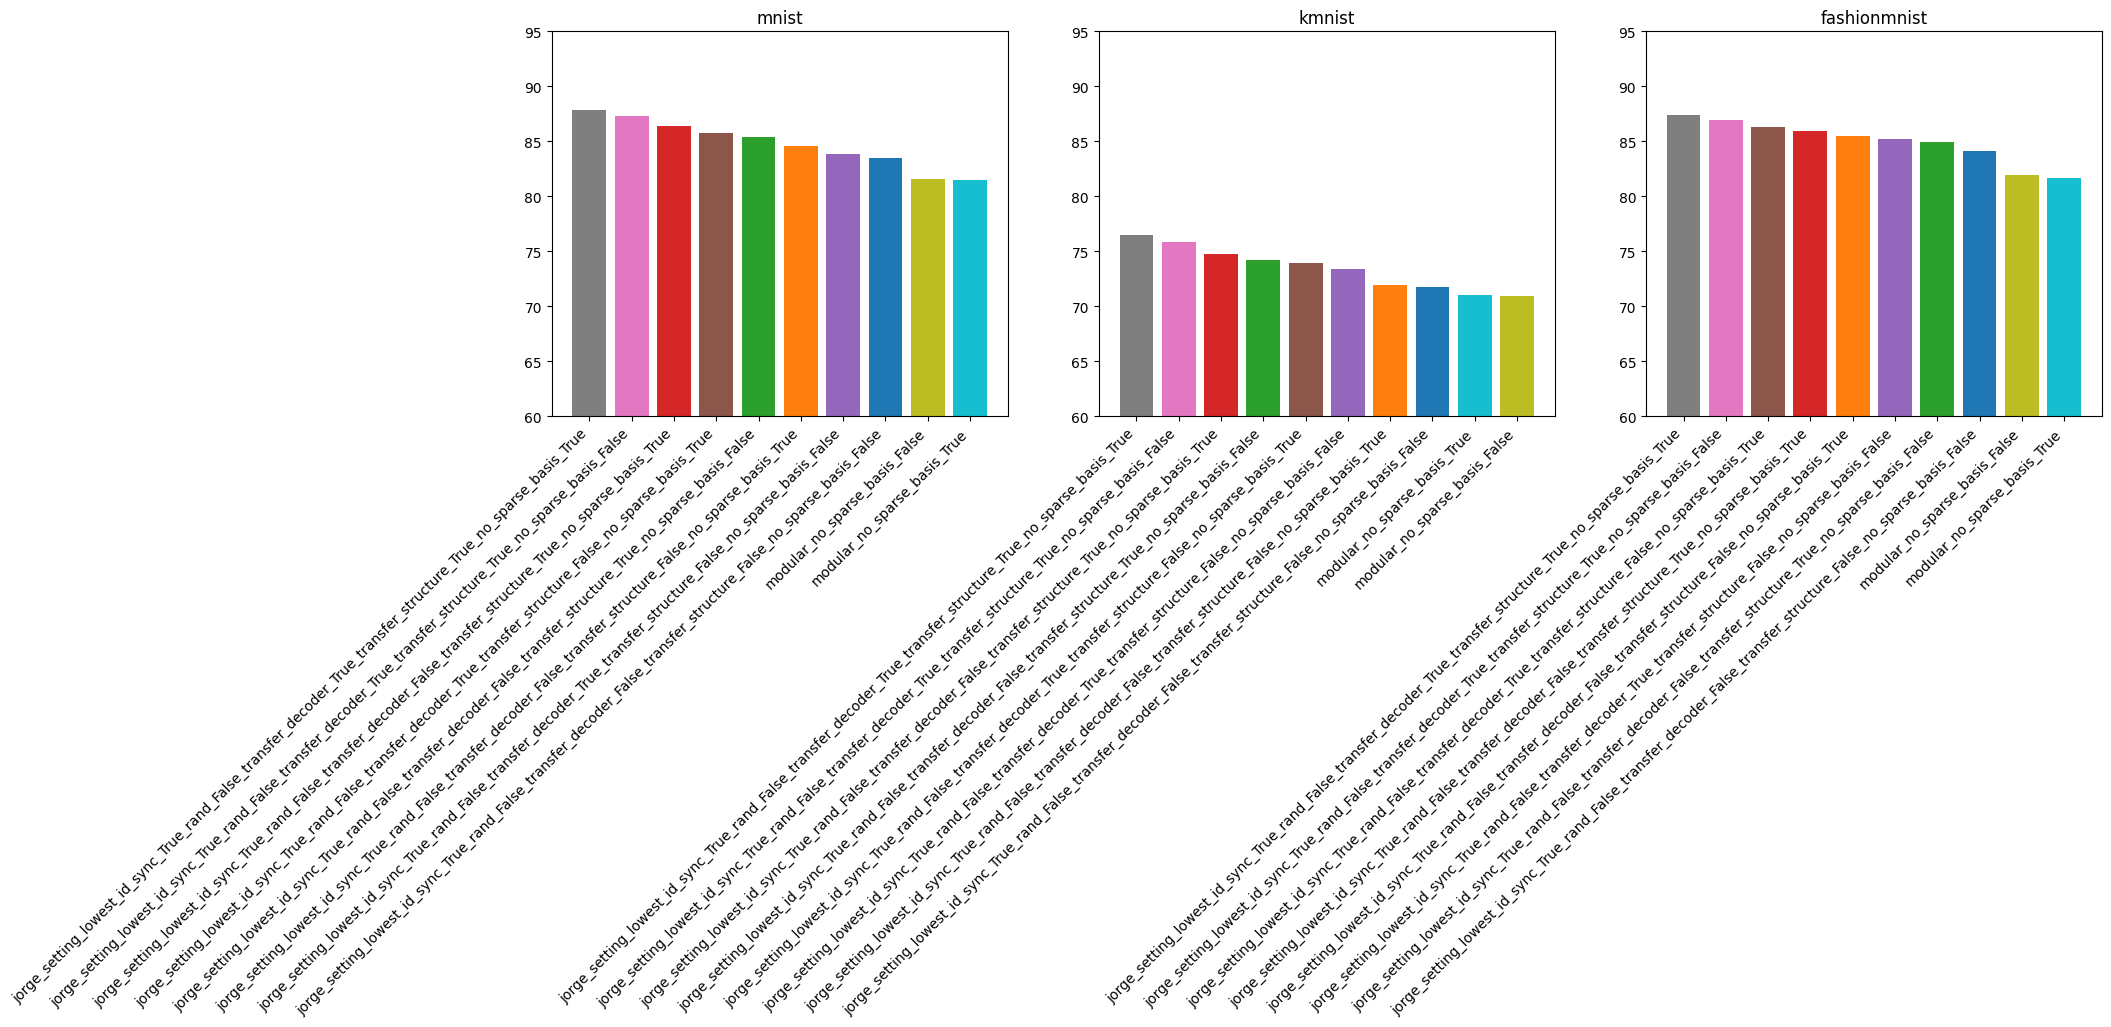

In [18]:
fig, ax = plt.subplots(1, len(dataset_seed_aucs.keys()), figsize=(20, 5))
for i, (dataset, seed_aucs) in enumerate(dataset_seed_aucs.items()):
    print('\n\n', dataset)
    plot_learning_curve_bars(seed_aucs, title_name=dataset,  ax=ax if not isinstance(ax, np.ndarray) else ax[i])